In [1]:
import numpy as np
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
iris = datasets.load_iris()


In [10]:
print("Iris dataset keys:", iris.keys())
print("Feature names:", iris.feature_names)
iris_data = iris.data
print("First 5 rows of data:\n", iris_data[:5][:, :2] )

Iris dataset keys: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
First 5 rows of data:
 [[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]]


In [12]:
X = iris.data[:, :2]
y = iris.target

In [15]:
mask = (y == 0) | (y == 1)# Keep only Setosa (0) and Versicolor (1) for linear separability

X = X[mask]
y = y[mask]

In [16]:
y = np.where(y == 0, -1, 1).astype(np.int64)


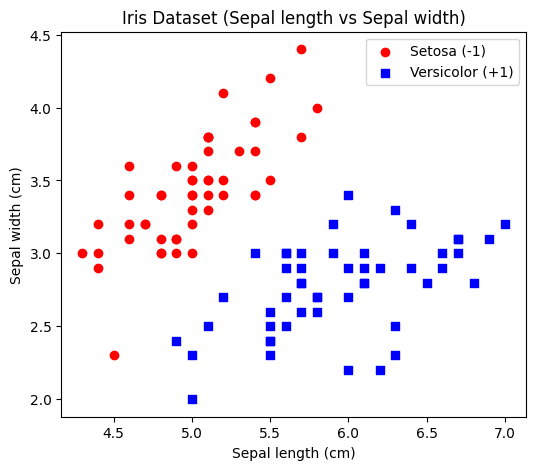

In [17]:
plt.figure(figsize=(6, 5))
plt.scatter(X[y == -1, 0], X[y == -1, 1], color="red", marker="o", label="Setosa (-1)")
plt.scatter(X[y ==  1, 0], X[y ==  1, 1], color="blue", marker="s", label="Versicolor (+1)")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Sepal width (cm)")
plt.title("Iris Dataset (Sepal length vs Sepal width)")
plt.legend()
plt.show()

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [19]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [20]:
X_train = torch.from_numpy(X_train_np).float().to(device)
y_train = torch.from_numpy(y_train_np).float().to(device)
X_test  = torch.from_numpy(X_test_np ).float().to(device)
y_test  = torch.from_numpy(y_test_np ).float().to(device)

In [21]:
#perceptron
model = torch.nn.Linear(in_features=2, out_features=1, bias=True).to(device)


In [22]:
with torch.no_grad():
    model.weight[:] = torch.randn_like(model.weight) * 0.01
    model.bias[:]   = torch.zeros_like(model.bias)

In [23]:
def perceptron_predict(logits: torch.Tensor) -> torch.Tensor:
    s = torch.sign(logits).view(-1)
    s = torch.where(s == 0, torch.tensor(1.0, device=logits.device), s)
    return s

In [27]:
lr = 0.1
epochs = 20

In [25]:
from tqdm import tqdm
import time

In [29]:
start_time = time.time()  # start timer

for epoch in tqdm(range(epochs), desc="Training epochs"):
    idx = torch.randperm(X_train.size(0), device=device)
    Xb, yb = X_train[idx], y_train[idx]

    mistakes = 0
    for xi, yi in zip(Xb, yb):
        logit = model(xi)
        yhat = perceptron_predict(logit)
        if yhat.item() != yi.item():
            mistakes += 1
            with torch.no_grad():
                model.weight[:] = model.weight + lr * yi * xi.view(1, -1)
                model.bias[:]   = model.bias + lr * yi

    with torch.no_grad():
        train_logits = model(X_train)
        train_pred   = perceptron_predict(train_logits)
        train_acc    = (train_pred == y_train).float().mean().item()

    tqdm.write(f"Epoch {epoch+1:02d} | mistakes: {mistakes:3d} | train acc: {train_acc:.3f}")

end_time = time.time()
print(f"\n⏱ Training completed in {end_time - start_time:.4f} seconds")

Training epochs:  15%|█▌        | 3/20 [00:01<00:05,  3.25it/s]

Epoch 01 | mistakes:   0 | train acc: 1.000
Epoch 02 | mistakes:   0 | train acc: 1.000
Epoch 03 | mistakes:   0 | train acc: 1.000
Epoch 04 | mistakes:   0 | train acc: 1.000


Training epochs:  55%|█████▌    | 11/20 [00:01<00:00, 13.85it/s]

Epoch 05 | mistakes:   0 | train acc: 1.000
Epoch 06 | mistakes:   0 | train acc: 1.000
Epoch 07 | mistakes:   0 | train acc: 1.000
Epoch 08 | mistakes:   0 | train acc: 1.000
Epoch 09 | mistakes:   0 | train acc: 1.000
Epoch 10 | mistakes:   0 | train acc: 1.000
Epoch 11 | mistakes:   0 | train acc: 1.000


Training epochs:  70%|███████   | 14/20 [00:01<00:00, 16.16it/s]

Epoch 12 | mistakes:   0 | train acc: 1.000
Epoch 13 | mistakes:   0 | train acc: 1.000
Epoch 14 | mistakes:   0 | train acc: 1.000
Epoch 15 | mistakes:   0 | train acc: 1.000
Epoch 16 | mistakes:   0 | train acc: 1.000
Epoch 17 | mistakes:   0 | train acc: 1.000


Training epochs: 100%|██████████| 20/20 [00:01<00:00, 12.01it/s]

Epoch 18 | mistakes:   0 | train acc: 1.000
Epoch 19 | mistakes:   0 | train acc: 1.000
Epoch 20 | mistakes:   0 | train acc: 1.000

⏱ Training completed in 1.6683 seconds


In [30]:
import os

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "perceptron_iris.pth")

torch.save(model.state_dict(), model_path)

print(f"✅ Model saved at: {model_path}")

✅ Model saved at: saved_models\perceptron_iris.pth


In [31]:
with torch.no_grad():
    test_logits = model(X_test)
    test_pred   = perceptron_predict(test_logits)
    test_acc    = (test_pred == y_test).float().mean().item()

print(f"\nTest accuracy: {test_acc:.3f}")


Test accuracy: 0.920


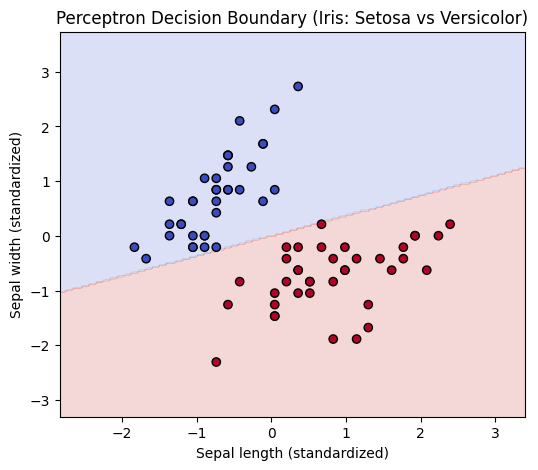

In [32]:
X_cpu = X_train.cpu().numpy()
y_cpu = y_train.cpu().numpy()

x_min, x_max = X_cpu[:, 0].min() - 1, X_cpu[:, 0].max() + 1
y_min, y_max = X_cpu[:, 1].min() - 1, X_cpu[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)
with torch.no_grad():
    Z = perceptron_predict(model(grid)).cpu().numpy()

Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
plt.scatter(X_cpu[:, 0], X_cpu[:, 1], c=y_cpu, cmap=plt.cm.coolwarm, edgecolors="k")
plt.xlabel("Sepal length (standardized)")
plt.ylabel("Sepal width (standardized)")
plt.title("Perceptron Decision Boundary (Iris: Setosa vs Versicolor)")
plt.show()

Optional for saved model

In [33]:
loaded_model = torch.nn.Linear(in_features=2, out_features=1, bias=True).to(device)

loaded_model.load_state_dict(torch.load(model_path, map_location=device))
loaded_model.eval()

print("🔄 Model loaded and ready for inference!")

🔄 Model loaded and ready for inference!


C:\Users\XS-AI-Hassan\AppData\Local\Temp\ipykernel_30560\340636997.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path, ma